## Using U-Net and Multisource imagery for Multiclass Classification of Forest Cover using in Alberta

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import os,sys

In [ ]:
#Authenticate to Colab and Cloud
from google.colab import auth
auth.authenticate_user

We do not have to upload data into Google cloud, particularly when we work with large satellite data. Therefore, we connect one folder on our PC with Google Drive. then we just place the data on our C drive and folder that is visible to cloud.

In [ ]:
root = "/content/drive/Othercomputers/My Computer/ML_workshop/"
%cd $root

In order to do processing within COLAB, utilizng standard memory and GPU will not be good enough. We have to purchase additional GPU Standard Class and High-RAM memory.
It will cost 14$ /month

### Import python libraries

In [ ]:
from PIL import Image 
import numpy as np 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random

In [ ]:
minmaxscaler = MinMaxScaler() #we need to scale the input data
!pip install patchify
#This function is related to CV2 library. It creates patches for training and prediction.


In [ ]:
from patchify import patchify
import cv2

In [ ]:
from osgeo import gdal 
import matplotlib 
import matplotlib.pyplot as plt
# import os,sys

In [ ]:
import random
import numpy as np



Since CV2 is intended to work with RGB (3) band data, we add GDAL so we can work with images having more than 3 bands. 

In our case we work with satellite multispectral data (6 bands),therefore we ought to use **GDAL and gdal_translate()** to crop the image. 

In [ ]:

dataset_name = "1300x1300"
#files in these folders were clip into sizes 1300 x 1300

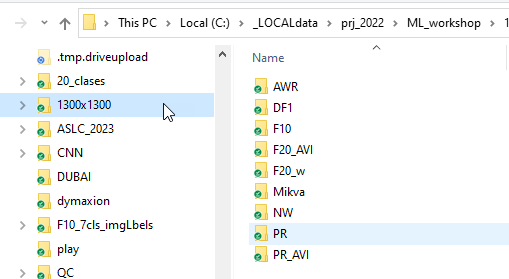

every folder on the right panel is a different project. wihtin each of these folders we have "images" and "labels" subfolders.

In [ ]:
print(os.walk(root))

In [ ]:
#to dispalay data within 'dataset_name' folder ***Print folders ******
for path,subdirs,files in os.walk(os.path.join(root,dataset_name)):
  dir_name = path.split(os.path.sep)[-1] #takes last folder
  print(dir_name)


In [ ]:
#to dispalay data within 'dataset_name' folder  ****print files ****
for path,subdirs,files in os.walk(os.path.join(root,dataset_name)):
  dir_name = path.split(os.path.sep)[-1]
  # print(dir_name)
  if dir_name == 'images':
    images = os.listdir(path) #makes a list of images
    print(len(images))
    # print("l:",len(images))
    for i , image_name in enumerate(images):
      if (image_name.endswith('.tif')):
        print(image_name)

In [ ]:
dataset = gdal.Open('/content/drive/Othercomputers/My Computer/ML_workshop/1300x1300/DF1/images/Df1_13_982_Alos2_150804_dual20m_CLIP_3bs_0_0.tif', gdal.GA_ReadOnly)
#dataset is an image

In [ ]:
#this reads image open in GDAL into an array
# Initialize a 3d array -- use the size properties of our image for portability!
image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),dtype = 'int16')

# Loop over all bands in dataset
for b in range(dataset.RasterCount):
    # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
    band = dataset.GetRasterBand(b + 1)
    
    # Read in the band's data into the third dimension of our array
    image[:, :, b] = band.ReadAsArray()

# print(image)
print(image.shape)
print(image.dtype)

In [ ]:
width=12
height=11
plt.figure(figsize=(width,height))
imgplot = plt.imshow(image[:,:,2])
plt.colorbar()

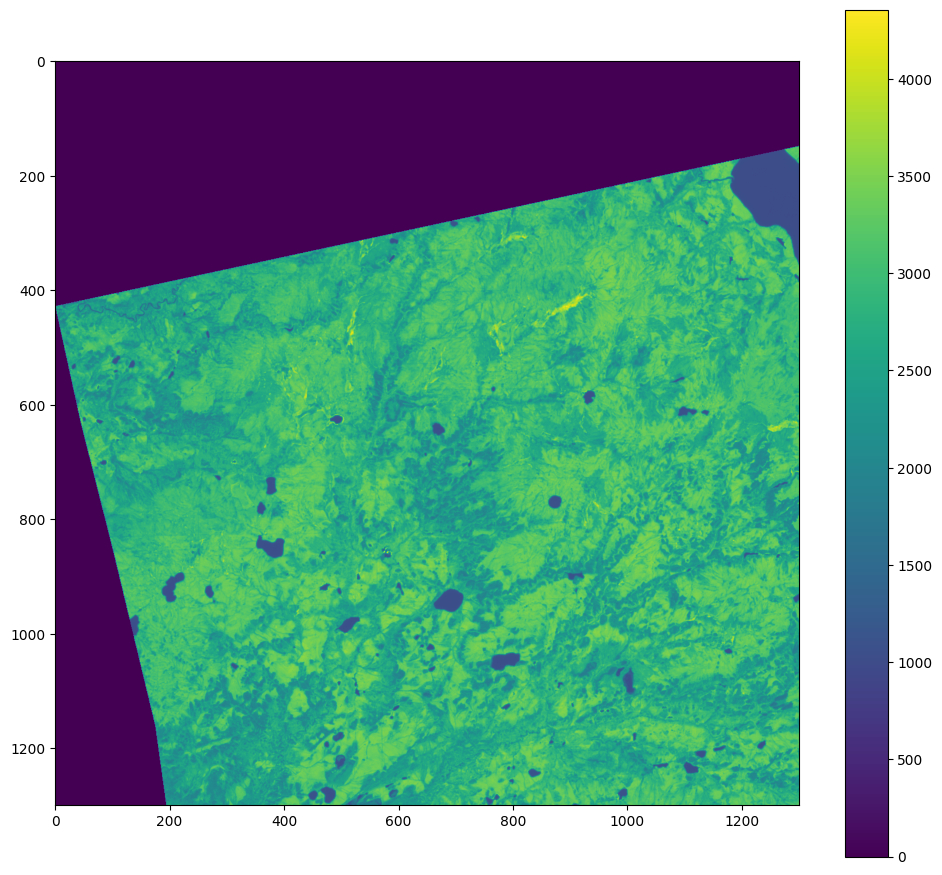

The large size of the images is prohibitive when training a deep neural network. This mainly is due to the limited GPU available resources. We need to split the images and their corresponding labels (masks) into patches ( tiles ). The same is done with labels (ground truth) image.  Patches can be stored in .tiff, numpy array ( .npy ) format or kept in memory.

our **patch size** is 256x256

In [ ]:
patch_size = 256
step_size = 256  #to get more patches we define step size
#if step size is equal to patch size, it means there is no overlap

In [ ]:
#to dispalay data within 'labels' folder
for path,subdirs,files in os.walk(os.path.join(root,dataset_name)):
  dir_name = path.split(os.path.sep)[-1]
  # print(dir_name)
  if dir_name == 'labels':
    masks = os.listdir(path)
    # print(path)
    # print("l:",len(images))
    for i , mask_name in enumerate(masks):
      if (mask_name.endswith('.tif')):
        print(mask_name)
#******************
print("*************")

# HOW DO WE CREATE Labels

We need most recent projects for Alberta Satellite Landcover Classification (ASLC ) update. Our ASLC codes go grom 10 (code for industrial) to 552 (young deciduous regen). 
We convert these ASLC codes into 20 classes ranging from 0 - 19. The first class start with 0 and it indicates burns Standing Dead(recent burn). 


## Visualize mask

Labels dataset is **1 band of Byte or 'uint16'**. 

It can be read by CV2 with parameter '-1' at the end. The main point here is that **extent of features-image** is equal to **extent of label dataset**. 

In [ ]:
bmask = cv2.imread("/content/drive/Othercomputers/My Computer/ML_workshop/1300x1300/DF1/labels/F10_DF1_13_20cls_150804final_byte_wBackground_0_0.tif",  -1)
plt.imshow(bmask)

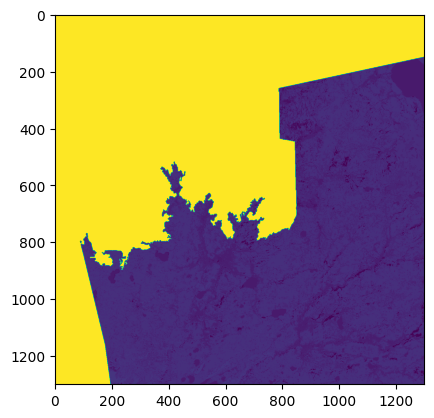

### Familiarize yourself with different classes in labels dataset. we have to find out what other erroneous values are present in our labels to remove them

In [ ]:
# labels, count = np.unique(amask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical. this is for more than 1 chanel
labels, count = np.unique(bmask, return_counts=True)
print("Labels are: ", labels, " and the counts are: ", count)

In [ ]:
def img2array(dataset):
  #''' read image into an array using gdal'''
    
    # Initialize a 3d array -- use the size properties of our image for portability!
    image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),dtype = 'int16')

    # Loop over all bands in dataset
    for b in range(dataset.RasterCount):
        # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
        band = dataset.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        image[:, :, b] = band.ReadAsArray()
        
    return image

# MODEL TRAINING 

# TRAINING PROCESS

## a) Features

#### First of all, we read out all our features and convert them into arrays.

We set up above our patch-size 256 and this is changeable.

#### Then we find out what is the maximum size of our features divisible with patch size.

####After that we use gdal.Translate() to crop an image  by maximum size divisible by patch_size.

This cropped image will be converted to an array with shape (6, 3328, 3072) for Bands,Rows,Cols. For patchify we need to transpose it into proper dimension which is (3328, 3072, 6)-Row-Cols-Bands.

#### print(img_array.shape) > (6, 3328, 3072) .Patches are made with the help of a function named patchify(). To use this function it is necessary to move number of channels to the last dimension of array.

###Move bands to the last dimension of array  **img_array = np.moveaxis(img_array, 0, 2) **  >(3328, 3072, 6)


####  Every image in folder is exposed to patchify library for the shape of patch size and number of bands.  we split every  input feature into small patches. We need to pay attention to patch size and number of bands in our features, when running 'patchify' 
At the end we get a list object which we convert to ndarray of size below.
<class 'list'>
(462, 256, 256, 6)  -#ofPatches-Rows-Cols-Bands

In [ ]:
images_list = []
temp = "/content/drive/Othercomputers/My Computer/ML_workshop/CNN"
for path,subdirs,files in os.walk(os.path.join(root,dataset_name)):
  dir_name = path.split(os.path.sep)[-1]
  #print("dir:",dir_name)
  if dir_name == 'images':
    images = os.listdir(path)
    #print("path:",path)
    #print("l:",len(images))
    for i , image_name in enumerate(images):
      if (image_name.endswith('.tif')):
        print(os.path.join(path,image_name))      
        
        dataset = gdal.Open(path+"/"+image_name, gdal.GA_ReadOnly)
        image = img2array(dataset)  #Read each image as BGR # use gdal==myarray = img2array(dataset )
        print(image.shape, image.dtype)       
 
           #we find size divisible with 256
        SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
        SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
        print("sizes:", SIZE_X,SIZE_Y)
        temp_out = os.path.join(temp,image_name).split('.')
        name_out = temp_out[0][:-9] + "_"+ str(SIZE_X )+ "_"+str(SIZE_Y) +'_'+str(i)+ '.'+temp_out[1]
        print("out:",name_out)
         #we convert array to image so we can crop it. Array cannot be croped
        # image = Image.fromarray(image) # this is for CV2
        # image_ds = dataset.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
        window = (0, 0, SIZE_X ,SIZE_Y)  #=(0 ,0, SIZE_X, SIZE_Y)
        # image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
        crop_ds = gdal.Translate(name_out, dataset, srcWin = window)
        # to get shape of cropped image  ds.RasterXSize,ds.RasterYSize)
        # print('({}, {})'.format(crop_ds.RasterXSize,crop_ds.RasterYSize))   #cv2 --- crop_ds.size[1]
        print(crop_ds.RasterXSize,crop_ds.RasterYSize)
        #   #Again we convert image to array so we can patchify
        # image = np.array(image)  #from PIL image to arrar        
        image = np.array(crop_ds.ReadAsArray())  #gdal way of converting image to an array
        print("img_shp:",image.shape) 
        image = np.transpose(image,(1,2,0)) 
        print("T-img_shp:",image.shape) 
        # #Step=256 for 256 patches means no overlap
        #patched_image = patchify(image,(patch_size,patch_size,6),step=patch_size)  #********* CHECK NUMBER OF BANDS AND ACCORDINGLY ADJUST
        patched_image = patchify(image,(patch_size,patch_size,3),step=step_size)  #********* CHECK NUMBER OF BANDS AND ACCORDINGLY ADJUST< Step_size, patch_size
        #print(len(patched_image))

        for i in range(patched_image.shape[0]):
          for j in range(patched_image.shape[1]):
            individual_patched_image = patched_image[i,j,:,:]
            #print(individual_patched_image.shape)
             #Use minmaxscaler instead of just dividing by 255. 
            individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1,individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
            individual_patched_image = individual_patched_image[0]
            # print(individual_patched_image.shape)
            images_list.append(individual_patched_image)
        dataset = None

In [ ]:
print(type(images_list))
images_dataset = np.array(images_list)
print(images_dataset.shape)

## b)Labels

we do all the same we have done with features. We crop the image for maximum size divisible by 256. then we convert to array. We do not do transpose because it is only one band. **I should try to transpose it** to see if it makes difference. We patchify all labels for the same inputs we did with features.

In [ ]:
mask_lista = [] 
temp = "/content/drive/Othercomputers/My Computer/ML_workshop/CNN"
for path,subdirs,files in os.walk(os.path.join(root,dataset_name)):

  dir_name = path.split(os.path.sep)[-1]
  #print("dir:",dir_name)
  if dir_name == 'labels':  #Find all 'labels' directories
    masks = os.listdir(path)  #List of all labels names in this subdirectory
    #print("path:",path)
    #print(masks)
    for i , mask_name in enumerate(masks):
      if (mask_name.endswith('.tif')): 
        print(os.path.join(path,mask_name))     
        dataset = gdal.Open(path+"/"+mask_name, gdal.GA_ReadOnly)
        mask = img2array(dataset)  #Read each image as BGR # use gdal==myarray = img2array(dataset )
        print(mask.shape, image.dtype) 
            #we find size divisible with 256
        SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
        SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
        print("sizes:", SIZE_X,SIZE_Y)
        temp_out = os.path.join(temp,image_name).split('.')
        name_out = temp_out[0][:-9] + "_"+ str(SIZE_X )+ "_"+str(SIZE_Y) +'_'+str(i)+ '.'+temp_out[1]
        print("out:",name_out)
        # mask = cv2.imread( path+"/"+mask_name   ,-1    ) 
        # print(mask.shape) 
        #  # mask = cv2.imread(path+ "/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer
        # image = Image.fromarray(image) # this is for CV2
        # image_ds = dataset.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
        window = (0, 0, SIZE_X ,SIZE_Y)  #=(0 ,0, SIZE_X, SIZE_Y)
        # image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
        crop_ds = gdal.Translate(name_out, dataset, srcWin = window)
        # to get shape of cropped image  ds.RasterXSize,ds.RasterYSize)
        # print('({}, {})'.format(crop_ds.RasterXSize,crop_ds.RasterYSize))   #cv2 --- crop_ds.size[1]
        print(crop_ds.RasterXSize,crop_ds.RasterYSize)
        #   #Again we convert image to array so we can patchify
        # image = np.array(image)  #from PIL image to arrar        
        mask = np.array(crop_ds.ReadAsArray())  #gdal way of converting image to an array
        print("img_shp:",image.shape) 
        # # image = np.transpose(image,(1,2,0)) 
        # print("T-img_shp:",image.shape) 
        # #Step=256 for 256 patches means no overlap
     
      
        # print("maskshape:",mask.shape) 
        patches_mask = patchify(mask, (patch_size,patch_size), step=step_size)  #Step=256 for 256 patches means no overlap #Check documentation to use stride to have more patches
        
        for i in range(patches_mask.shape[0]):
          for j in range(patches_mask.shape[1]):
                                       
            single_patch_mask = patches_mask[i,j,:,:]
            print("single:",single_patch_mask.shape)
            #single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds. 
            # print(single_patch_mask.shape)
            #print("singleDrop:",single_patch_mask.shape)                              
            mask_lista.append(single_patch_mask)
        dataset = None

In [ ]:
#convert a list to a np.array
my_labels = np.array(mask_lista)

In [ ]:
print(my_labels.shape)
#(539, 256, 256, 3)

In [ ]:
print(len(my_labels), "img:",len(images_dataset))

# BOTH VALUES MUST BE THE EQUAL 1138 img: 1138

In [ ]:
labeli, counts = np.unique(my_labels, return_counts=True)
print("Labels are: ", labeli, " and the counts are: ", counts)

We need remove all unique values GT 20 and make sure again if our labels are 'uint8'. Here in one F20 label NoDATA value appear with -128 value which makes my label 'uint16'. 

In [ ]:
my_labels[my_labels > 20]= 0  #Dump class 15 into a background value of 0

In [ ]:
my_labels.dtype
#Shapes: Images: (Band, col, row ) ----> Raster: (Col, row, band)

## visualize feature and labels

we have to make sure that label file match feature file

In [ ]:
# Display image data and labels. they have to match
random_image_id = random.randint(0, len(images_dataset))  #
plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(images_dataset[random_image_id,:,:,2])
plt.colorbar()
# plt.imshow(np.reshape(images_dataset[random_image_id],(patch_size,patch_size,3)))
plt.subplot(122)
plt.imshow(my_labels[random_image_id])  # When label is a one chanel.


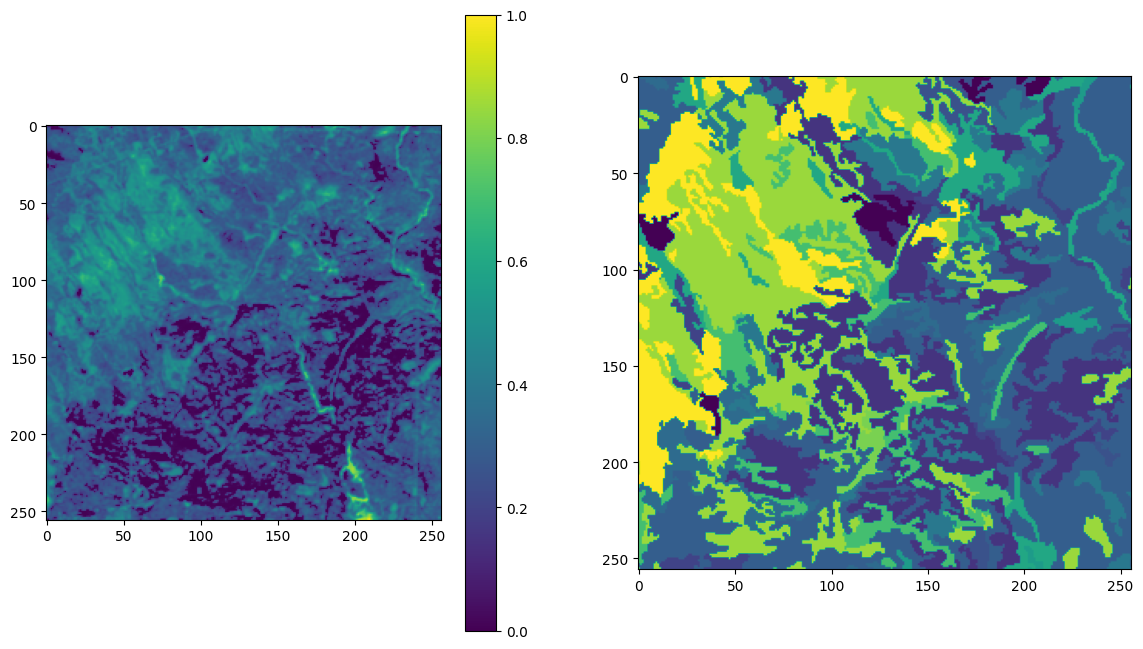

In [ ]:

from tensorflow.keras.utils import to_categorical 
from sklearn.model_selection import train_test_split

### CHECK IF LABELS ARE IN  *'uint8'*

###Hot encoding is done to convert our classes to categorical

In [ ]:
print(my_labels.dtype, my_labels.shape) 
labels_categorical_dataset = to_categorical(my_labels, num_classes=total_classes)   ##NOTE: labels must be 'uint8'

All 6 pixels (6 bands) / 3 pixels (3 bands) in a 20x20 m will be evaluated against 20 different classes. One of the 20 values which is highest will be selected by argmax() and that will be ultimate class. If thathighest value pixel has index 19, then it will belong to young deciduous which is 552 and that was remaped to class 19

In [ ]:
master_trianing_dataset = images_dataset #images_dataset 
master_trianing_dataset.shape

###  SPLIT our dataset to training and testing using 85%:15% ratio

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [ ]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

## Visualize histogram of training data

In [ ]:
fig,axs = plt.subplots()
axs.hist(X_train.flatten(),bins= 50)

## PART TWO

In [ ]:
# PART TWO
#import Tensorflow 1.x
!pip install -U segmentation-models

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
from keras import backend as K  #because keras is high level it needs to be defined in separate cell

In [ ]:
import segmentation_models as sm
from keras import backend as K
#to have keras.utils.get_custom_objects().update ...
#this cell will throw an error. just follow coment below..

/usr/local/lib/python3.8/dist-packages/efficientnet/__init__.py in init_keras_custom_objects()

## click on th link and change keras.utils so that you delete 'generic_utils' and then do Cntr 'S' to save it

In [ ]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

### U-net moded definition

In [ ]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs
  #16 filters and kernel is 3by3
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)  #from c1 (at the end) input we drop out 20% and get new c1 output
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)  #we pull c1 input to get p1. 'p' is for Pooling
  #HERE WE DOUBLE FILTERS
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)
  
  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)  #KERNEL IS 1BY1
  #outputs = Conv2D(n_classes, (1,1), activation="softmax")(p1)  #in case of commenting out most of the model
  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [ ]:
metrics = ["accuracy", jaccard_coef]
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

In [ ]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes, 
                          image_height=image_height, 
                          image_width=image_width, 
                          image_channels=image_channels)

In [ ]:
model = get_deep_learning_model()

## Generating Loss Function

dice loss > Focal Loss > Total Loss Total Loss = (Dice loss + (1*Focal Loss))

it is an extension to crosentropy.

In [ ]:
#create equal weights for each class
weights_20 = [0.0476, 0.0476, 0.0476, 0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476]   #For simplicity here, We use equal class weights. In the next run we will calculate them


In [ ]:
dice_loss = sm.losses.DiceLoss(class_weights = weights_20)

In [ ]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [ ]:
total_loss = dice_loss + (1 * focal_loss)  #our loss function from sm models

## Model compilation

In [ ]:
import tensorflow as tf

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [ ]:
model.summary()

In [ ]:
import keras
from IPython.display import clear_output

In [ ]:
class PlotLoss(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []

    self.jaccard_coef = []
    self.val_jaccard_coef = []

    self.fig = plt.figure()
    self.logs = []

  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(logs)
    self.x.append(self.i)
    # self.losses.append(logs.get('loss'))
    # self.val_losses.append(logs.get('val_loss'))

    self.jaccard_coef.append(logs.get('jaccard_coef'))
    self.val_jaccard_coef.append(logs.get('val_jaccard_coef'))

    self.i += 1
    
    clear_output(wait=True)
    # plt.plot(self.x, self.losses, label="loss")
    # plt.plot(self.x, self.val_losses, label="val_loss")

    plt.plot(self.x, self.jaccard_coef, label="jaccard_coef")
    plt.plot(self.x, self.val_jaccard_coef, label="val_jaccard_coef")

    plt.legend()
    plt.show();

plot_loss = PlotLoss()

In [ ]:
class PlotLossEx(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []

    self.losses = []
    self.val_losses = []

    self.jaccard_coef = []
    self.val_jaccard_coef = []

    self.fig = plt.figure()
    self.logs = []

  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(logs)
    self.x.append(self.i)

    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    self.jaccard_coef.append(logs.get('jaccard_coef'))
    self.val_jaccard_coef.append(logs.get('val_jaccard_coef'))

    self.i += 1

    plt.figure(figsize=(14,8))
    f, (graph1, graph2) = plt.subplots(1,2, sharex=True)
    
    clear_output(wait=True)

    graph1.set_yscale('log')
    graph1.plot(self.x, self.losses, label="loss")
    graph1.plot(self.x, self.val_losses, label="val_loss")
    graph1.legend()

    graph2.set_yscale('log')
    graph2.plot(self.x, self.jaccard_coef, label="jaccard_coef")
    graph2.plot(self.x, self.val_jaccard_coef, label="val_jaccard_coef")
    graph2.legend()

    plt.show();

plot_loss = PlotLossEx()

In [ ]:
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=100,    #200,
                          validation_data=(X_test, y_test),
                          callbacks=[plot_loss],  #local debuging
                          # callbacks=[WandbCallback()],  #remote debuging
                          shuffle=False)

In [ ]:
history_a = model_history

In [ ]:
history_a.history

In [ ]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model_history.params

In [ ]:
y_pred = model.predict(X_test)
#there are 70 patches for X_test

In [ ]:
len(y_pred)

In [ ]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [ ]:
len(y_pred_argmax)

In [ ]:
# y_pred_argmax 
y_test_argmax = np.argmax(y_test, axis=3)
#for each pixel with 7 layers argmax will determine to which class each pixel belong to
# y_test_argmax

#Comparing prediction results

using test images using mask images and predicted result images..

In [ ]:
import random

In [ ]:

test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]  ##//////////??????????????????????

In [ ]:
predicted_image 
test_image.shape

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
#imgplot = plt.imshow(image[:,:,2])
plt.imshow(test_image[:,:,2])
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)

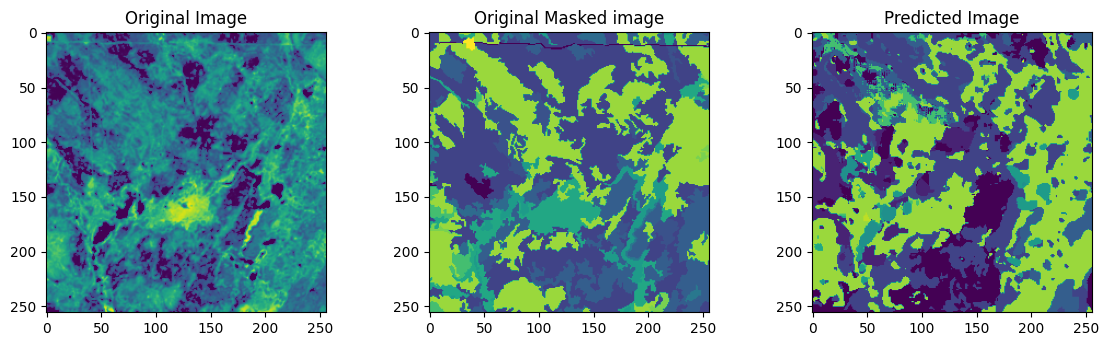

## Model saving and reloading (with custom loss and custom metrics)

* loss

'dice_loss_plus_1focal_loss': total_loss

* Metrics

jaccard_coef: jaccard_coef

In [ ]:
#Saving the model
#model.get_config()
model.save("ASLC_20clas_gdal_try_100ep_16batch_3band_48accApril20.h5")

In [ ]:
#Loading the saved model for prediction
saved_model = load_model('/content/drive/Othercomputers/My Computer/ML_workshop/ASLC_20clas_gdal_try_100ep_16batch_3band_48accApril20.h5',
                         custom_objects=({'dice_loss_plus_1focal_loss': total_loss, 
                                          'jaccard_coef': jaccard_coef}))

## Performing Prediction using the sample of Sentinel-2/Alos-2 stack with the same bands that went into training model.
Data for prediction must be patched with same size 256x256. Because this patch size was used as an input for model training. Then for prediction we use the same patch size to create image chips

In [ ]:
pred_ds = gdal.Open('/content/drive/Othercomputers/My Computer/ML_workshop/QC/F10_4predic_256x256.tif', gdal.GA_ReadOnly)  #gdal

#pred_ds is an image
#convert image to an array
image = img2array(pred_ds)  #Read each image as BGR # use gdal==myarray = img2array(dataset )
print(image.shape, image.dtype)
#(256, 256, 6) int16

In [ ]:
# shape of our input images is    #ofPatches,Cols, rows, bands
#that is why for prediction image we need to do expansion of dimensions to (1, 256, 256, 6)
image = np.expand_dims(image, 0)
print(image.shape)
#(1, 256, 256, 6)

In [ ]:
prediction = saved_model.predict(image)

In [ ]:
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]